# Exploratory analysis : NLP FOMC Project

In [126]:
#!pip install wordcloud

In [641]:
import numpy as np
import pandas as pd
from urllib import request
import bs4
from wordcloud import WordCloud, STOPWORDS 
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import re
import itertools
import datetime as dt

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [609]:
df = pd.read_csv("/Users/h2jw/Documents/GitHub/NLP-FOMC/RA_project/final_df_v4.csv", low_memory=True)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [610]:
df  = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1','Unnamed: 0.1.1.1'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126782 entries, 0 to 126781
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               126782 non-null  object 
 1   interlocutor_name  126782 non-null  object 
 2   statement _size    126782 non-null  int64  
 3   statement          126725 non-null  object 
 4   statement_number   126782 non-null  object 
 5   chair_in_charge    126782 non-null  object 
 6   score_acadam       126782 non-null  float64
 7   score_hostile      126782 non-null  float64
 8   score_econo        126782 non-null  float64
 9   score_virtue       126782 non-null  float64
 10  score_vice         126782 non-null  float64
 11  score_hawkish      126782 non-null  float64
 12  score_posi         126782 non-null  float64
 13  score_affi         126782 non-null  float64
 14  score_uncert       126782 non-null  float64
 15  Affil              126782 non-null  float64
 16  Ho

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [611]:
df.head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_acadam,score_hostile,score_econo,score_virtue,...,NUMB,Yes,No,Negate,SureLw,If,NotLw,RspGain,ABS,Causal
0,1976-08-17,CHAIRMAN BURNS,41,we are ready to start our meeting this morning...,statement_0,CHAIRMAN BURNS,0.0,0.04878,0.024390,0.048780,...,0.048780,0.0,0.02439,0.024390,0.048780,0.000000,0.024390,0.02439,0.024390,0.024390
1,1976-08-17,MR HOLMES,2,statementsee appendix,statement_1,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,1976-08-17,MR BLACK,27,alan do you think that through realignment of ...,statement_2,CHAIRMAN BURNS,0.0,0.00000,0.037037,0.037037,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.074074,0.037037
3,1976-08-17,MR HOLMES,49,there are two alternatives one that everybody ...,statement_3,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.081633,0.0,0.00000,0.020408,0.020408,0.040816,0.020408,0.00000,0.061224,0.020408
4,1976-08-17,MR BLACK,8,which do you think would be more likely?,statement_4,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.125000,0.000000


## Preprocessing

La base s'arrête en 2014, on va rajouter le scrapping de 2015 avec les codes contenus dans `codes scrapping`.

In [653]:
# add 2015 update
df.Date = df.Date.astype('datetime64')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Chairs

In [654]:
pd.unique(df.chair_in_charge)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<StringArray>
[    'CHAIRMAN BURNS',    'CHAIRMAN MILLER',   'CHAIRMAN VOLCKER',
 'CHAIRMAN GREENSPAN',  'CHAIRMAN BERNANKE',       'CHAIR YELLEN']
Length: 6, dtype: string

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'Chair person')

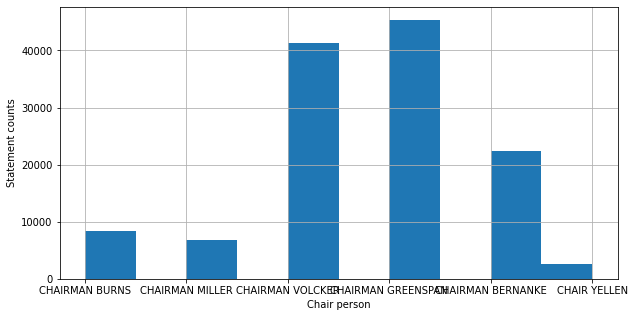

In [655]:
plt.figure(figsize=(10,5))
df['chair_in_charge'].hist()
plt.ylabel('Statement counts')
plt.xlabel('Chair person')

In [656]:
#pd.unique(df['interlocutor_name'])

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [657]:
def name_cleaning(name_list):
    # Removing punctuations in string
    # Using regex
    cleaned = []
    stopname_list=['CHAIRMAN', 'MS', 'VICE', 'MR']
    for name in name_list:
        res = re.sub(r'[^\w\s]', '', name)
        # printing result
        # print("The string after punctuation filter : " + res)
        
        res = ' '.join([word for word in res.split() if word not in stopname_list])
        cleaned.append(res)
    return cleaned
def get_role(name_list):
    role = []
    stopname_list=['CHAIRMAN', 'MS', 'VICE', 'MR']
    for name in name_list:
        res = re.sub(r'[^\w\s]', '', name)
        res = ' '.join([word for word in res.split() if word in stopname_list])
        role.append(res)
        
    return role

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [658]:
df['role_int']= get_role(df.interlocutor_name.tolist())
df['interlocutor_name']=name_cleaning(df.interlocutor_name.tolist())

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [659]:
pd.unique(df.interlocutor_name)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['BURNS', 'HOLMES', 'BLACK', 'PARDEE', 'COLDWELL', 'PARTEE',
       'EASTBURN', 'WALLICH', 'JACKSON', 'GARDNER', 'BAUGHMAN', 'GRAMLEY',
       'WINN', 'KIMBREL', 'AXILROD', 'MAYO', 'WILLIAMS', 'GUFFEY',
       'MORRIS', 'VOLCKER', 'MACLAURY', 'BROIDA', 'ZEISEL', 'BALLES',
       'STERNLIGHT', 'LILLY', 'ROOS', 'MACCLAURY', 'PAULUS', 'REYNOLDS',
       'VAN', 'KICHLINE', 'WILLES', 'FOSSUM', 'MEEK', 'ALTMANN', 'TRUMAN',
       'RANKIN', 'COYNE', 'SICILIANO', 'SMOOT', 'WILLIS', 'ETTIN',
       'GUENTHER', 'WALLACE', 'MAYOMR', 'MILLER', 'DENKLER', 'MORIARTY',
       'CZERWINSKI', 'TEETERS', 'OCONNELL', 'BAUGHWJV', 'MACDONALD',
       'ALTMA', 'HOMES', 'GAINOR', 'WALLJCH', 'MCINTOSH', 'GREENE',
       'RICE', 'FARNSWORTH', 'ROBINSON', 'TIMLEN', 'PRELL', 'SCHULTZ',
       'VOLCRER', 'KIMEREL', 'SCWLTZ', 'VOLCKFR', 'BECK', 'SIMPSON',
       'LINDSEY', 'KERAN', 'FORRESTAL', 'SOLOMON', 'PETERSEN', 'FORD',
       'KEIR', 'CORRIGAN', 'GRALEY', 'OLTMAN', 'BOEHNE', 'BOYKIN',
       'DOYLE', 'K

In [660]:
df_small = df.head(40000)
df_small = df_small.groupby('interlocutor_name').agg({'statement':'count'})

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:ylabel='statement'>

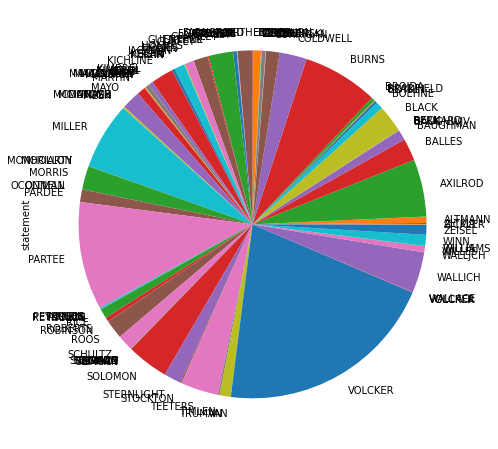

In [661]:
fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('white')
df_small.statement.plot.pie()

### Statements

In [612]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['mr','re', 's', 'it', 'ex', 'in', 'he', 'and', 'there', 'however', 'to', 'now', 'to', 'of', 'the', 'they', 'but', 'soon', 'film', 'that', 'who', 'of'])


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /Users/h2jw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [613]:
df.head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_acadam,score_hostile,score_econo,score_virtue,...,NUMB,Yes,No,Negate,SureLw,If,NotLw,RspGain,ABS,Causal
0,1976-08-17,CHAIRMAN BURNS,41,we are ready to start our meeting this morning...,statement_0,CHAIRMAN BURNS,0.0,0.04878,0.024390,0.048780,...,0.048780,0.0,0.02439,0.024390,0.048780,0.000000,0.024390,0.02439,0.024390,0.024390
1,1976-08-17,MR HOLMES,2,statementsee appendix,statement_1,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,1976-08-17,MR BLACK,27,alan do you think that through realignment of ...,statement_2,CHAIRMAN BURNS,0.0,0.00000,0.037037,0.037037,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.074074,0.037037
3,1976-08-17,MR HOLMES,49,there are two alternatives one that everybody ...,statement_3,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.081633,0.0,0.00000,0.020408,0.020408,0.040816,0.020408,0.00000,0.061224,0.020408
4,1976-08-17,MR BLACK,8,which do you think would be more likely?,statement_4,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.125000,0.000000


In [614]:
df.statement = df.statement.astype('string')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


On va "nettoyer" les statements des STOPWORDS.

In [615]:
df.statement = df.statement.fillna('')
df['statement'] = df['statement'].str.replace('[^\w\s]','') # remove punctuation

df["statement"] = df["statement"].str.lower().str.split() # get words with lowercase 

df['statement'] = df['statement'].apply(lambda x: [item for item in x if item not in stop]) # remove stopwords
df.statement.head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-615-18fa842569a1>:2: DeprecationWarning: invalid escape sequence \w
  df['statement'] = df['statement'].str.replace('[^\w\s]','') # remove punctuation


0    [ready, start, meeting, morning, first, item, ...
1                             [statementsee, appendix]
2    [alan, think, realignment, currencies, europea...
3    [two, alternatives, one, everybody, goes, floa...
4                               [think, would, likely]
Name: statement, dtype: object

In [618]:
df.statement = df.statement.astype('string')
df['statement'] = df['statement'].str.replace('[^\w\s]','')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-618-5e7f52f24d3a>:2: DeprecationWarning: invalid escape sequence \w
  df['statement'] = df['statement'].str.replace('[^\w\s]','')


In [619]:
df_lda = df
df_lda[['statement']].head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,statement
0,ready start meeting morning first item busines...
1,statementsee appendix
2,alan think realignment currencies european com...
3,two alternatives one everybody goes floats sep...
4,think would likely


## Quelques statistiques descriptives...

- Wordclouds par "Chair in charge"

In [620]:
def nuage_de_mots(text): 
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = STOPWORDS # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()   
    

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [621]:
df.statement

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0         ready start meeting morning first item busines...
1                                     statementsee appendix
2         alan think realignment currencies european com...
3         two alternatives one everybody goes floats sep...
4                                        think would likely
                                ...                        
126777    worries happened one time chairman bernankes w...
126778    thank okay think main open issue statement bra...
126779    vote chair yellen indicated alternative b depi...
126780    okay thank much let confirm next meeting held ...
126781                           thank madam chair december
Name: statement, Length: 126782, dtype: string

In [622]:
df_small = df.head(40000)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


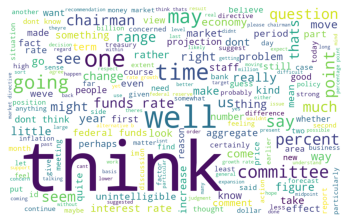

Wordcloud associé à la chair BURNS


In [623]:
df_statement = df_small.groupby('chair_in_charge')['statement'].apply(' '.join)
nuage_de_mots(df_statement.iloc[[0]][0])  
print("Wordcloud associé à la chair BURNS")

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


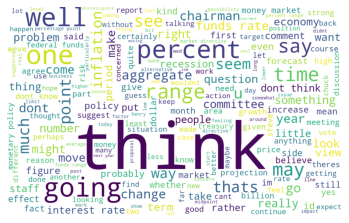

Wordcloud associé à la chair MILLER


In [624]:
nuage_de_mots(df_statement.iloc[[1]][0]) 
print("Wordcloud associé à la chair MILLER")

In [625]:
df_statement

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


chair_in_charge
CHAIRMAN BURNS      ready start meeting morning first item busines...
CHAIRMAN MILLER     well join us arrives first start procedural ma...
CHAIRMAN VOLCKER    might say benefit come little executive sessio...
Name: statement, dtype: object

### Tests de LDA 
#### Approche *bag of words*
- LDA sur l'ensemble des statements. 
- LDA sur Chair Burns, Chair Miller et Chair Greenspan

On a considéré comme document l'ensemble des statements ou l'ensemble des statements prononcé sous une chair (Burns, Miller ou Greenspan). 


In [183]:
#!pip install pyldavis

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn


def LDA_on_dataset(series, n_topic): #notre LDA prend en entrée le series.dataframe contenant l'information textuelle 
                                      #et le nombre de topic à modéliser
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=1000)
    tfidf = tfidf_vectorizer.fit_transform(series)

    lda = LatentDirichletAllocation(n_components=n_topic, max_iter=5,
                                  learning_method='online',
                                  learning_offset=50.,
                                  random_state=0)
    lda.fit(tfidf)
    LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=n_topic, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

    tf_feature_names = tfidf_vectorizer.get_feature_names()

    return pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)



In [258]:
print('Statement : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_lda.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.157810  0.008014       1        1  56.890696
3      0.105286  0.178667       2        1  14.985557
4      0.131522  0.137375       3        1  11.606850
0      0.077030 -0.348080       4        1   8.483345
1     -0.471648  0.024024       5        1   8.033553, topic_info=          Term          Freq         Total Category  logprob  loglift
647  president  10440.000000  10440.000000  Default  30.0000  30.0000
878      thank   5894.000000   5894.000000  Default  29.0000  29.0000
368   governor   4495.000000   4495.000000  Default  28.0000  28.0000
991        yes   3444.000000   3444.000000  Default  27.0000  27.0000
586       okay   3283.000000   3283.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
606       page      0.195757    482.650526   Topic5 -12.0294  -5.2886
317    finally      0.193506    169.563184   Topic5 -12.0410  -4.2541
45      answer      0.194791    365.729799   Topic5 -12.0344  -5.0162
322      first      0.195730   1401.907640   Topic5 -12.0296  -6.3551
238        don      0.194186   1597.461956   Topic5 -12.0375  -6.4936

[299 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3         1  0.174981      accept
3         3  0.819424      accept
24        1  0.176634  aggregates
24        3  0.821734  aggregates
26        1  0.269788       agree
...     ...       ...         ...
989       4  0.401820        year
991       5  0.999723         yes
997       1  0.998259         you
998       1  0.019320       youre
998       4  0.980466       youre

[488 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

In [251]:
df_burns = df_lda[df_lda.chair_in_charge == 'CHAIRMAN BURNS']
df_miller = df_lda[df_lda.chair_in_charge == 'CHAIRMAN MILLER']

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [255]:
print('Statement Burns : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_burns.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Burns : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.103025  0.019884       1        1  48.242706
3      0.122128  0.173416       2        1  18.392287
0      0.029734 -0.204654       3        1  16.517910
1     -0.394276  0.035087       4        1   9.586978
4      0.139388 -0.023734       5        1   7.260120, topic_info=       Term        Freq       Total Category  logprob  loglift
568      mr  572.000000  572.000000  Default  30.0000  30.0000
897   thank  272.000000  272.000000  Default  29.0000  29.0000
647  please  237.000000  237.000000  Default  28.0000  28.0000
898    that  269.000000  269.000000  Default  27.0000  27.0000
969    well  297.000000  297.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
365   going   14.845332  113.768059   Topic5  -4.8784   0.5863
963     way   13.173022   76.157216   Topic5  -4.9979   0.8681
601     one   12.043567  138.698717   Topic5  -5.0875   0.1790
355     get   11.702951   91.952807   Topic5  -5.1162   0.5613
281    even   11.545003   58.570160   Topic5  -5.1298   0.9988

[308 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5         2  0.840347  accounts
5         3  0.076395  accounts
7         1  0.104696       act
7         3  0.889914       act
16        1  0.092740  adjusted
...     ...       ...       ...
997       5  0.500304       yet
999       1  0.379425       you
999       2  0.440622       you
999       3  0.146874       you
999       4  0.036719       you

[581 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])

In [254]:
print('Statement Miller : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_miller.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Miller : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.071625 -0.061479       1        1  65.769742
4     -0.053794  0.296858       2        1  10.731505
3     -0.148441 -0.082027       3        1   9.567390
0      0.339093 -0.026251       4        1   7.659058
1     -0.065233 -0.127100       5        1   6.272304, topic_info=        Term        Freq       Total Category  logprob  loglift
872    thank  247.000000  247.000000  Default  30.0000  30.0000
992      yes  240.000000  240.000000  Default  29.0000  29.0000
141    chuck  109.000000  109.000000  Default  28.0000  28.0000
737    right  119.000000  119.000000  Default  27.0000  27.0000
874    thats  112.000000  112.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
328  foreign   20.028476   50.022509   Topic5  -4.1412   1.8537
563      new   15.653411   34.592611   Topic5  -4.3876   1.9761
482     line   15.689073   35.727537   Topic5  -4.3854   1.9461
178    could   16.514572   96.635508   Topic5  -4.3341   1.0023
958     well   12.956112  159.204653   Topic5  -4.5768   0.2604

[246 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
22        2  0.860648      agenda
24        1  0.979524  aggregates
29        1  0.036834        alan
29        2  0.847191        alan
29        3  0.073669        alan
...     ...       ...         ...
995       1  0.041333        york
995       5  0.909322        york
996       1  0.232631         you
996       2  0.021148         you
996       3  0.740188         you

[404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

In [256]:
df_greenspan = df_lda[df_lda.chair_in_charge == 'CHAIRMAN GREENSPAN']

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [257]:
print('Statement Greenspan : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_greenspan.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Miller : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.193199  0.015443       1        1  40.456062
0      0.209096  0.008848       2        1  39.608957
3     -0.197378 -0.381319       3        1   6.860028
4      0.155182  0.094060       4        1   6.764059
2     -0.360099  0.262967       5        1   6.310895, topic_info=           Term         Freq        Total Category  logprob  loglift
645   president  4998.000000  4998.000000  Default  30.0000  30.0000
358    governor  2965.000000  2965.000000  Default  29.0000  29.0000
747       right  1108.000000  1108.000000  Default  28.0000  28.0000
886       thank  1075.000000  1075.000000  Default  27.0000  27.0000
887        that   997.000000   997.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
744     revised     0.283578    46.598261   Topic5 -10.4362  -2.3389
991         yes     0.289667  1034.924273   Topic5 -10.4150  -5.4182
949        vice     0.288644   416.676684   Topic5 -10.4185  -4.5120
224  discussion     0.287930   296.978092   Topic5 -10.4210  -4.1758
313       first     0.286796   389.133965   Topic5 -10.4249  -4.4500

[287 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
10        1  0.925301  activity
10        2  0.071177  activity
22        1  0.066081     agree
22        2  0.451174     agree
22        3  0.480797     agree
...     ...       ...       ...
991       2  0.096625       yes
997       1  0.123265       you
997       2  0.876551       you
998       2  0.984522     youre
998       5  0.009467     youre

[461 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

On va chercher à observer/mesurer l'impact d'un changement de chair sur un membre ayant fait plusieurs chairs.

Les chairs se succèdent selon la temporalité suivante : 
- 08/1976 : Chair Burns
- 01/1978 : Chair Miller
- 08/1979 : Chair Volcker
- 08/1987 : Chair Greenspan
- 08/2006 : Chair Bernanke
- 01/2014 : Chair Yellen

Observons arbitrairement les individus tandem entre la chair Volcker et la chair Greenspan puis chair Bernanke et chair Greenspan. 

In [662]:
df.chair_in_charge = df.chair_in_charge.astype('string')
#df.Date = df.Date.astype('datetime64')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sélection des statements de la chair Volcker et de la chair Greenspan. 

In [663]:
mask = (df.chair_in_charge == "CHAIRMAN VOLCKER") + (df.chair_in_charge == "CHAIRMAN GREENSPAN")
df1  = df[mask]
df1

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_acadam,score_hostile,score_econo,score_virtue,...,Yes,No,Negate,SureLw,If,NotLw,RspGain,ABS,Causal,role_int
15170,1979-08-14,VOLCKER,636,might say benefit come little executive sessio...,statement_0,CHAIRMAN VOLCKER,0.007862,0.022013,0.036164,0.051887,...,0.009434,0.000000,0.006289,0.034591,0.018868,0.004717,0.001572,0.034591,0.020440,CHAIRMAN
15171,1979-08-14,WALLICH,21,possible figure unrealized gain loss account t...,statement_1,CHAIRMAN VOLCKER,0.000000,0.000000,0.095238,0.000000,...,0.000000,0.000000,0.047619,0.047619,0.095238,0.000000,0.000000,0.000000,0.095238,MR
15172,1979-08-14,FARNSWORTH,25,governor wallich today dave robinson manager a...,statement_2,CHAIRMAN VOLCKER,0.000000,0.080000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,MR
15173,1979-08-14,VOLCKER,11,account talking domestic foreign,statement_3,CHAIRMAN VOLCKER,0.000000,0.000000,0.090909,0.000000,...,0.000000,0.000000,0.090909,0.090909,0.181818,0.000000,0.000000,0.000000,0.090909,CHAIRMAN
15174,1979-08-14,WALLICH,35,domestic foreign side take rule fasb requires ...,statement_4,CHAIRMAN VOLCKER,0.000000,0.000000,0.000000,0.028571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101794,2006-01-31,GREENSPAN,28,gather correctly theres real interest reversin...,statement_164,CHAIRMAN GREENSPAN,0.000000,0.035714,0.071429,0.035714,...,0.000000,0.035714,0.035714,0.035714,0.035714,0.035714,0.000000,0.071429,0.071429,CHAIRMAN
101795,2006-01-31,DANKER,185,thank chairman decision go ahead status quo wa...,statement_165,CHAIRMAN GREENSPAN,0.010811,0.005405,0.048649,0.021622,...,0.054054,0.000000,0.005405,0.059459,0.010811,0.000000,0.000000,0.032432,0.016216,MS
101796,2006-01-31,GREENSPAN,19,request federal reserve board engage addressin...,statement_166,CHAIRMAN GREENSPAN,0.052632,0.000000,0.105263,0.052632,...,0.000000,0.000000,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,CHAIRMAN
101797,2006-01-31,GREENSPAN,27,federal reserve board voted unanimously accept...,statement_167,CHAIRMAN GREENSPAN,0.037037,0.000000,0.074074,0.037037,...,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000,0.000000,0.037037,0.037037,CHAIRMAN


Sélection des individus ayant prononcé des statements sur les deux chair.

In [665]:
df1['Date_max']= df1.Date
df1.assign(Date_max=df1.Date)
df_interlocutor = df1.groupby('interlocutor_name').agg({'Date':'min', 'Date_max':'max', 'statement':' '.join})

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-665-86843f144477>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date_max']= df1.Date


In [666]:
df_interlocutor.head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Date_max,statement
interlocutor_name,,,
,1996-12-17,1997-09-30,president jordan last time looked issue year a...
ALEXANDER,1999-02-03,1999-02-03,main changes forecast international side drive...
ALTMA,1979-09-18,1979-10-06,chairman volcker yes president balles presiden...
ALTMANN,1979-08-14,1982-12-21,yes change authorization foreign currency oper...
ANGELL,1986-02-12,1993-12-21,hesitate make governor seger incorrect point f...


In [667]:
df_interlocutor.Date = df_interlocutor.Date.astype('datetime64')
df_interlocutor.Date_max = df_interlocutor.Date_max.astype('datetime64')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [675]:
mask_volcker = (df_interlocutor.Date.dt.strftime('%Y-%m') >= '1979-08') & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < '1987-08')
mask_greenspan = (df_interlocutor.Date.dt.strftime('%Y-%m') >= '1987-08') & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < '2006-08')
mask_tandem = (df_interlocutor.Date.dt.strftime('%Y-%m') <= '1987-08') & (df_interlocutor.Date_max.dt.strftime('%Y-%m')< "2006-08")
df_volcker = df_interlocutor[mask_volcker]
df_greenspan = df_interlocutor[mask_greenspan]
df_tandem = df_interlocutor[mask_volcker & mask_greenspan]

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [701]:
df_volcker['length']=df_volcker['Date_max']-df_volcker['Date']
df_volcker['statement_size']=df_volcker.statement.str.len()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-701-52fcc50d2d94>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volcker['length']=df_volcker['Date_max']-df_volcker['Date']
<ipython-input-701-52fcc50d2d94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [727]:
df_volcker.sort_values(by='length', ascending=False).head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Date_max,statement,length,statement_size
interlocutor_name,,,,,
VOLCKER,1979-08-14,1987-07-07,might say benefit come little executive sessio...,2884 days,1660156
KICHLINE,1979-09-18,1987-05-19,statementsee appendix dont account revisions a...,2800 days,167134
RICE,1979-08-14,1986-11-05,chairman listened interest comments beginning ...,2640 days,106054
WALLICH,1979-08-14,1986-09-23,possible figure unrealized gain loss account t...,2597 days,224134
AXILROD,1979-08-14,1986-04-01,president balles measure fiscal policy effects...,2422 days,395194


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if compare_axis == "x":


<AxesSubplot:xlabel='length', ylabel='statement_size'>

<Figure size 1440x720 with 0 Axes>

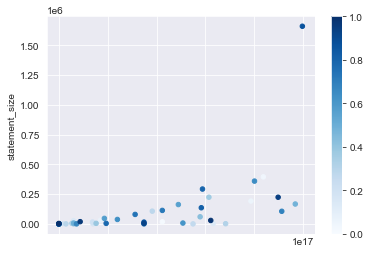

In [728]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
df_volcker.plot.scatter(x='length', y='statement_size', c=np.linspace(0,1, len(df_volcker)), colormap='Blues')


In [729]:
pd.unique(df_tandem.index)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([], dtype=object)

Il n'y a apparemment pas de personnes sur les deux mandats de chair...

In [732]:
df_greenspan['length']=df_greenspan['Date_max']-df_greenspan['Date']
df_greenspan.sort_values('length', ascending=False).head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-732-0e1057d93709>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_greenspan['length']=df_greenspan['Date_max']-df_greenspan['Date']


,Date,Date_max,statement,length
interlocutor_name,,,,
GREENSPAN,1987-08-18,2006-01-31,longer pause expected laughter id like enterta...,6741 days
GUYNN,1987-12-16,2006-01-31,first time process fascinating economic develo...,6621 days
MATTINGLY,1989-10-03,2004-06-30,thats youd governor vote directors bank ratify...,5384 days
HOENIG,1991-10-01,2006-01-31,matter fact thats warning chairman want hear d...,5236 days
MCTEER,1991-02-06,2004-09-21,peter said authority pay interest required res...,4976 days


In [734]:
df_greenspan.sort_values('Date_max', ascending=False).head(10)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Date_max,statement,length
interlocutor_name,,,,
LACKER,2004-06-30,2006-01-31,first let add cathys commendations joe linda e...,580 days
FERGUSON,1997-11-12,2006-01-31,thank chairman already said room many reports ...,3002 days
MINEHAN,1994-03-22,2006-01-31,thank chairman trust wont either question comm...,4333 days
STRUCKMEYER,2001-06-27,2006-01-31,dan described data use analysis supply side ec...,1679 days
HOENIG,1991-10-01,2006-01-31,matter fact thats warning chairman want hear d...,5236 days
MOSKOW,1994-09-27,2006-01-31,chairman economic activity seventh district re...,4144 days
GUYNN,1987-12-16,2006-01-31,first time process fascinating economic develo...,6621 days
STOCKTON2,2006-01-31,2006-01-31,thank chairman years back noted briefings coul...,0 days
GREENSPAN,1987-08-18,2006-01-31,longer pause expected laughter id like enterta...,6741 days


On va essayer d'implémenter une LDA sur ces individus pour le chair Greenspan et pour le chair Miller.

In [671]:
print(len(df_tandem))

55


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [672]:
print('Statement tandem : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_tandem.statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement tandem : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.004240 -0.000112       1        1  92.414825
3      0.001094  0.000285       2        1   2.183574
2      0.001063 -0.000668       3        1   2.113081
1      0.000726  0.001188       4        1   1.644753
4      0.001356 -0.000693       5        1   1.643767, topic_info=        Term      Freq     Total Category  logprob  loglift
988    would  2.000000  2.000000  Default  30.0000  30.0000
621  percent  1.000000  1.000000  Default  29.0000  29.0000
886    think  1.000000  1.000000  Default  28.0000  28.0000
695     rate  1.000000  1.000000  Default  27.0000  27.0000
963     well  1.000000  1.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
679      put  0.011686  0.636141   Topic5  -6.7339   0.1111
510   market  0.011867  0.862259   Topic5  -6.7185  -0.1776
541    money  0.011769  0.908714   Topic5  -6.7268  -0.2384
757   saying  0.011658  0.690036   Topic5  -6.7362   0.0275
79       bad  0.011562  0.581458   Topic5  -6.7445   0.1904

[267 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
30        1  1.717208        ahead
38        1  1.165364  alternative
52        1  1.822767      appears
57        1  1.466562         area
79        1  1.719814          bad
...     ...       ...          ...
963       1  0.773802         well
988       1  0.824679        would
991       1  1.055193         year
993       1  1.131082          yes
997       1  1.506102        youre

[96 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

#### Approche avec *word2vec*